In [50]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage #for 3D median
from skimage import io, color #for rgb2lab and rgb2hsv
from skimage.morphology import disk #for disk structured element


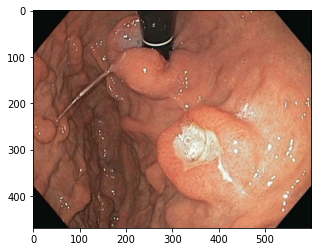

In [51]:
# image =cv.imread('dataset/images/image_1.png')
# image =cv.imread('dataset/images/image_2.png')
image =cv.imread('dataset/images/image_3.png')

image =cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)


<h3>Top-Hat filtre</h3>
<p>The top-hat filter is used to enhance bright objects of interest in a dark background</p>

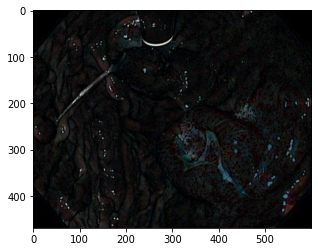

In [52]:
# beta :: stretching parameter
beta=12

#StructuringElement : disk Forme - because it's more commonly used for medical images
kernel = disk(beta)

# Applying the Top-Hat operation
topHat_img = cv.morphologyEx(image,cv.MORPH_TOPHAT,kernel)

plt.imshow(topHat_img)

<h3>Bottom(black)-Hat filtre</h3>
<p>Bottom-Hat filter is used to do the opposite of top-hat, enhance dark objects of interest in a bright background</p>

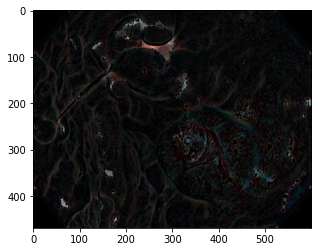

In [53]:
#StructuringElement : disk Forme - because it's more commonly used for medical images
kernel = disk(beta)

# Applying the Black-Hat operation
bottomHat_img = cv.morphologyEx(image, cv.MORPH_BLACKHAT,kernel)

plt.imshow(bottomHat_img)

<h3>Combine top-bottom with image</h3>
<p>
    It is possible to add the bright areas to the image and subtract the dark areas from it. <br>As a result, there will be an enhancement in the contrast between bright and dark areas: <br>
    <strong>  I(contrast enhanced) = I + topHat(I) - bottomHat(I) </strong> 
</p>


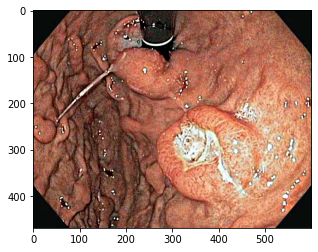

In [54]:
topBottom_img=cv.subtract(cv.add(topHat_img,image), bottomHat_img)
plt.imshow(topBottom_img)

<h3>Applicated Median filter</h3>
<p>
    3D median filter is applied to remove the salt and pepper noise, and improve the image from extra noise
</p>

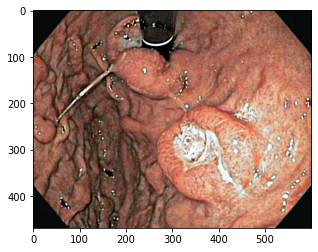

In [55]:
#alpha :: size of median filter
alpha = (3, 3, 3)
median_topBottom_img= scipy.ndimage.median_filter(topBottom_img, alpha)
plt.imshow(median_topBottom_img)


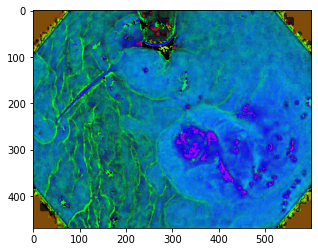

In [56]:
sample=median_topBottom_img
sample_h= color.rgb2hsv(sample)
plt.imshow(sample_h)


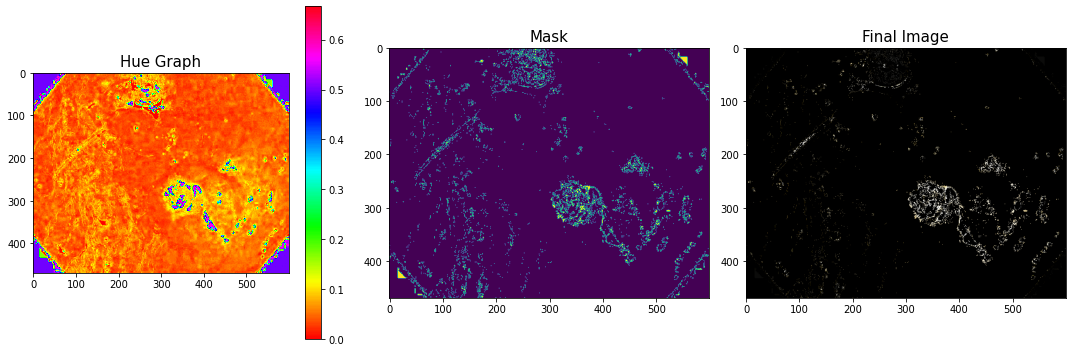

In [57]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(sample_h[:,:,0],cmap='hsv')
fig.colorbar(im,ax=ax[0])
ax[0].set_title('Hue Graph',fontsize=15)

#set the lower and upper mask based on hue colorbar value of the desired fruit
lower_mask = sample_h[:,:,0] > 0.11
upper_mask = sample_h[:,:,0] < 0.3
mask = upper_mask*lower_mask

# get the desired mask and show in original image
red = sample[:,:,0]*mask
green = sample[:,:,1]*mask
blue = sample[:,:,2]*mask
mask2 = np.dstack((red,green,blue))
ax[1].imshow(mask)
ax[2].imshow(mask2)
ax[1].set_title('Mask',fontsize=15)
ax[2].set_title('Final Image',fontsize=15)
plt.tight_layout()
plt.show()

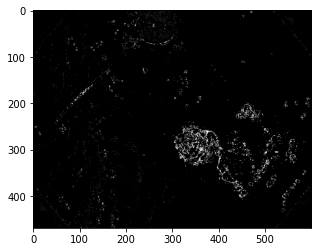

In [58]:
img_ulcer=cv.cvtColor(mask2, cv.COLOR_RGB2GRAY)
plt.imshow(img_ulcer,cmap='gray')

(469, 600, 3)


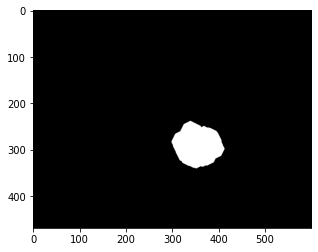

In [59]:
ret, thresh = cv.threshold(mask2,np.mean(median_topBottom_img),255,cv.THRESH_BINARY)

kernel = disk(3)
thresh = cv.erode(cv.dilate(thresh,kernel,iterations=2),kernel,iterations=7)

segmentation=cv.dilate(thresh,kernel,iterations=7)
print(segmentation.shape)
plt.imshow(segmentation, cmap = 'gray')


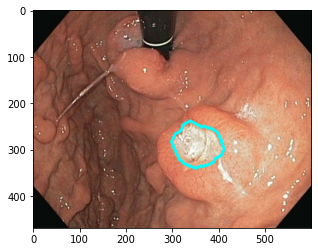

In [60]:

# Load images as greyscale but make main RGB so we can annotate in color
# seg  = cv.imread(segmentation,cv.IMREAD_GRAYSCALE)
seg  = cv.cvtColor(segmentation, cv.COLOR_RGB2GRAY)
main = image.copy()

# Dictionary giving RGB color for label (segment label) - label 1 in red, label 2 in yellow
RGBforLabel = { 1:(0,0,255), 2:(1,255,255) }

# Find external contours
contours,_ = cv.findContours(seg,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)

# Iterate over all contours
for i,c in enumerate(contours):
    # Find mean color inside this contour by doing a masked mean
    mask = np.zeros(seg.shape, np.uint8)
    cv.drawContours(mask,[c],-1,255, -1)
    # DEBUG: cv.imwrite(f"mask-{i}.png",mask)
    mean,_,_,_ = cv.mean(seg, mask=mask)
    # DEBUG: print(f"i: {i}, mean: {mean}")

    # Get appropriate color for this label
    label = 2 if mean > 1.0 else 1
    color = RGBforLabel.get(label)
    # DEBUG: print(f"color: {color}")

    # Outline contour in that color on main image, line thickness=1
    cv.drawContours(main,[c],-1,color,5)

# Save result
# cv.imwrite('result.png',main) 
plt.imshow(main)